In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from datetime import datetime as dt
from pandas_datareader import DataReader as DR
import seaborn as sb
import numdifftools as nd
from wquantiles import quantile
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF

from scipy.stats import norm,t,truncnorm
from scipy.stats import multivariate_normal as mvnorm
from scipy.stats import multivariate_t as mvt
from scipy.spatial import Delaunay as TRI
from scipy.interpolate import LinearNDInterpolator as ITP
from scipy.optimize import minimize,root
from scipy.optimize import NonlinearConstraint as NonlinCons
from scipy.stats import gaussian_kde as sciKDE

from sklearn.linear_model import LinearRegression as Linear
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.neighbors import KernelDensity as sklKDE

import warnings
warnings.filterwarnings("ignore")

# Define the experiment class

In [2]:
class MLE:
    def __init__(self,dim,alpha,sigma,size,df=1):
        self.alpha=alpha
        self.VaR=norm.ppf(alpha)
        aVar=np.array([alpha*(1-alpha),4*(alpha*(1-alpha))**2])/norm.pdf(self.VaR)**2
        aErr=np.sqrt(aVar/size)
        print('Reference for a-var & a-err (direct, optimal): {} & {}'.format(np.round(aVar,4),np.round(aErr,4)))
        
        self.dim=dim
        self.T=lambda x: mvnorm.pdf(x=x,mean=np.zeros(dim))
        self.oP=lambda x,VaR: self.T(x)*np.abs(1.0*(x[:,0]<VaR)-self.alpha)/(2*self.alpha*(1-self.alpha))
        self.iP=lambda x: mvt.pdf(x=x,loc=np.zeros(dim),shape=sigma**2,df=df)
        self.iS=lambda size: mvt.rvs(size=size,loc=np.zeros(dim),shape=sigma**2,df=df)
        self.size=size
        
    def __estimate(self,S,W,name,asym=True):
        self.eVaR=quantile(S[:,0],W,self.alpha)
        err=self.eVaR-self.VaR
        if asym:
            w=W/np.sum(W)
            aVar=np.sum((w*(1.0*(S[:,0]<=self.eVaR)-self.alpha))**2)*W.size
            aVar/=norm.pdf(self.VaR)**2
            aErr=np.sqrt(aVar/W.size)
            ESS=1/np.sum(w**2)
            
            Wf=W*(S[:,0]<self.eVaR)
            wf=Wf/np.sum(Wf)
            ESSf=1/np.sum(wf**2)
            print('{} est: {:.4f}; err: {:.4f}; a-var: {:.4f}; a-err: {:.4f}; ESS: {:.0f}/{}; ESS(f): {:.0f}/{}'\
                  .format(name,self.eVaR,err,aVar,aErr,ESS,W.size,ESSf,W.size))
        else:
            print('{} est: {:.4f}; err: {:.4f}'.format(name,self.eVaR,err))
            
        if any(W<0):
            W[W<0]=0
            self.eVaR=quantile(S[:,0],W,self.alpha)
            err=self.eVaR-self.VaR
            print('(adjusted) {} est: {:.4f}; err: {:.4f}'.format(name,self.eVaR,err))
        
    def estimate_IS(self):
        S=self.iS(self.size)
        W=self.T(S)/self.iP(S)
        self.__estimate(S,W,'IS')
    
    def draw_TP(self,P,x,name,dim=0):
        X=np.zeros([x.size,self.dim])
        X[:,dim]=x
        fig,ax=plt.subplots(figsize=(7,4))
        ax.plot(x,self.T(X))
        ax.plot(x,self.oP(X,self.VaR))
        ax.plot(x,P(X))
        if name=='nonparametric':
            one=np.zeros(self.dim)
            one[dim]=1
            rW=np.array([self.h(one*loc,loc) for loc in self.rS])
            rW=rW/rW.max()*P(X).max()
            rWmeans=np.ones_like(rW)*rW.mean()

            ax.plot(x,self.mP(X))
            ax.hist(self.rS[:,dim],bins=2*rW.size,weights=rWmeans)
            ax.hist(self.rS[:,dim],bins=2*rW.size,weights=rW)
            ax.legend(['target','optimal proposal','nonparametric proposal',\
                       'mixture proposal','centers','centers with weight'])
        elif name=='regression':
            rT=self.T(X)*(1.0*(X[:,0]<self.VaR)-self.alpha)/norm.pdf(self.VaR)
            G=self.G(X)
            oR=self.reg3.coef_.dot(G)/norm.pdf(self.VaR)
            
            ax.plot(x,rT)
            ax.plot(x,oR)
            ax.legend(['target','optimal proposal','mixture proposal',\
                       'regression target','ordinary regression'])
            ax.plot(x,np.zeros_like(x),'k--')
        else:
            ax.legend(['target','optimal proposal','{} proposal'.format(name)])
            
        ax.set_title('{}-D target and {} proposal (cross-sectional view)'.format(self.dim,name))
        plt.show()
        
    def resample(self,size,ratio):
        S=self.iS(ratio*size)
        p=self.oP(S,self.eVaR)/self.iP(S)
        index=np.arange(S.shape[0])
        choice=np.random.choice(index,size,p=p/np.sum(p),replace=True)
        
        self.rS=S[choice]
        self.rSset=S[list(set(choice))]
        print('resampling rate: {}/{}'.format(self.rSset.shape[0],size))
        
    def estimate_NIS(self,rate,bdwth='scott',kde=0):
        if kde==0:
            self.kde=sciKDE(self.rS.T,bw_method=bdwth)
            cov=self.kde.covariance_factor()*np.cov(self.rS.T)
            print('bdwth: {}'.format(np.round(np.sqrt(np.diag(cov)),2)))
            self.h=lambda x,loc: mvnorm.pdf(x=x,mean=loc,cov=cov)
            self.nP=lambda x: self.kde.pdf(x.T)
            self.nS=lambda size: self.kde.resample(size).T
        else:
            rS1=self.rS[self.rS[:,0]<=self.eVaR]
            rS2=self.rS[self.rS[:,0]>self.eVaR]
            self.kde1=sciKDE(rS1.T,bw_method=bdwth)
            self.kde2=sciKDE(rS2.T,bw_method=bdwth)
            cov1=self.kde1.covariance_factor()*np.cov(rS1.T)
            cov2=self.kde2.covariance_factor()*np.cov(rS2.T)
            print('bdwth 1: {}'.format(np.round(np.sqrt(np.diag(cov1)),2)))
            print('bdwth 2: {}'.format(np.round(np.sqrt(np.diag(cov2)),2)))
            tmp=np.copy(self.eVaR)
            self.h=lambda x,loc: mvnorm.pdf(x=x,mean=loc,cov=cov1 if loc[0]<=tmp else cov2)
            rate0=rS1.shape[0]/(rS1.shape[0]+rS2.shape[0])
            self.nP=lambda x: rate0*self.kde1.pdf(x.T)+(1-rate0)*self.kde2.pdf(x.T)
            self.nS=lambda size: np.vstack([self.kde1.resample(round(rate0*size)).T,\
                                            self.kde2.resample(size-round(rate0*size)).T])
            
        def G(x):
            tmp=np.array([self.h(x,loc) for loc in self.rSset])
            return tmp[1:]-tmp.mean(axis=0)

        self.G=G
            
        S=self.nS(self.size)
        W=self.T(S)/self.nP(S)
        self.__estimate(S,W,'NIS')
        
        self.mP=lambda x: (1-rate)*self.iP(x)+rate*self.nP(x)
        self.mS=lambda size: np.vstack([self.iS(size-round(rate*size)),self.nS(round(rate*size))])
        self.S=self.mS(self.size)
        W=self.T(self.S)/self.mP(self.S)
        self.__estimate(self.S,W,'MIS')
        
    def estimate_RIS(self):
        X=(self.G(self.S)/self.mP(self.S)).T
        tmp=X/np.linalg.norm(X,axis=0)
        lbd=np.linalg.eigvals(tmp.T.dot(tmp))
        tau=np.sqrt(lbd.max()/lbd)
        print('Condition index: (min {:.4f}, median {:.4f}, mean {:.4f}, max {:.4f}, [>30] {}/{})'\
              .format(tau.min(),np.median(tau),tau.mean(),tau.max(),np.sum(tau>30),tau.size))
        
        y2=self.T(self.S)/self.mP(self.S)
        y1=y2*(self.S[:,0]<=self.eVaR)
        y3=y1-self.alpha*y2
        self.reg1=Linear().fit(X,y1)
        self.reg2=Linear().fit(X,y2)
        self.reg3=Linear().fit(X,y3)
        print('Tail R2: {:.4f}; Body R2: {:.4f}; Total R2: {:.4f}'\
              .format(self.reg1.score(X,y1),self.reg2.score(X,y2),self.reg3.score(X,y3)))
        
        W2=y2-X.dot(self.reg2.coef_)
        W3=y3-X.dot(self.reg3.coef_)
        aVar=np.sum(W3**2)/(np.sum(W2))**2
        aVar=W2.size*aVar/norm.pdf(self.VaR)**2
        aErr=np.sqrt(aVar/W2.size)
        print('RIS a-var: {:.4f}; a-err: {:.4f}'.format(aVar,aErr))
        
    def estimate_MLE(self,opt=True,NR=True):
        mP=self.mP(self.S)
        G=self.G(self.S)
        target=lambda zeta: -np.mean(np.log(mP+zeta.dot(G)))
        gradient=lambda zeta: -np.mean(G/(mP+zeta.dot(G)),axis=1)
        hessian=lambda zeta: (G/(mP+zeta.dot(G))**2).dot(G.T)/G.shape[1]
        zeta0=np.zeros(G.shape[0])
        grad0=gradient(zeta0)
        print('MLE reference:')
        print('origin: value: {:.4f}; grad: (min {:.4f}, mean {:.4f}, max {:.4f}, std {:.4f})'\
              .format(target(zeta0),grad0.min(),grad0.mean(),grad0.max(),grad0.std()))
        
        print()
        print('Theoretical results:')
        X=(G/mP).T
        XX=X-X.mean(axis=0)
        zeta1=np.linalg.solve(XX.T.dot(XX),X.sum(axis=0))
        print('MLE(The) zeta: (min {:.4f}, mean {:.4f}, max {:.4f}, std {:.4f}, norm {:.4f})'\
              .format(zeta1.min(),zeta1.mean(),zeta1.max(),zeta1.std(),np.sqrt(np.sum(zeta1**2))))
        grad1=gradient(zeta1)
        print('theory: value: {:.4f}; grad: (min {:.4f}, mean {:.4f}, max {:.4f}, std {:.4f})'\
              .format(target(zeta1),grad1.min(),grad1.mean(),grad1.max(),grad1.std()))
        W=(self.T(self.S)/mP)*(1-XX.dot(zeta1))
        print('reg weights: (min {:.4f}, mean {:.4f}, max {:.4f}, [<0] {}/{})'\
              .format(W.min(),W.mean(),W.max(),np.sum(W<0),W.size))
        self.__estimate(self.S,W,'RIS',asym=False)
        W=self.T(self.S)/(mP+zeta1.dot(G))
        print('mle weights (The): (min {:.4f}, mean {:.4f}, max {:.4f}, [<0] {}/{})'\
              .format(W.min(),W.mean(),W.max(),np.sum(W<0),W.size))
        self.__estimate(self.S,W,'MLE(The)',asym=False)
        
        if opt:
            zeta=zeta1 if target(zeta1)!=np.nan else zeta0
            begin=dt.now()
            if NR:
                res=root(lambda zeta: (gradient(zeta),hessian(zeta)),zeta,method='lm',jac=True)
            else:
                cons=({'type':'ineq','fun':lambda zeta: mP+zeta.dot(G),'jac':lambda zeta: G.T})
                res=minimize(target,zeta,method='SLSQP',jac=gradient,constraints=cons,\
                             options={'ftol':1e-8,'maxiter':1000})
            
            end=dt.now()
            print()
            print('Optimization results (spent {} seconds):'.format((end-begin).seconds))
            if res['success']:
                zeta=res['x']
                print('MLE(Opt) zeta: (min {:.4f}, mean {:.4f}, max {:.4f}, std {:.4f}, norm {:.4f})'\
                      .format(zeta.min(),zeta.mean(),zeta.max(),zeta.std(),np.sqrt(np.sum(zeta**2))))
                print('Dist(zeta(Opt),zeta(The))={:.4f}'.format(np.sqrt(np.sum((zeta-zeta1)**2))))
                grad=gradient(zeta)
                print('optimal: value: {:.4f}; grad: (min {:.4f}, mean {:.4f}, max {:.4f}, std {:.4f})'\
                      .format(target(zeta),grad.min(),grad.mean(),grad.max(),grad.std()))
                W=self.T(self.S)/(mP+zeta.dot(G))
                print('mle weights (Opt): (min {:.4f}, mean {:.4f}, max {:.4f}, [<0] {}/{})'\
                      .format(W.min(),W.mean(),W.max(),np.sum(W<0),W.size))
                self.__estimate(self.S,W,'MLE(Opt)',asym=False)
            else:
                print('MLE fail')

# Run the experiments

==IS==================================================IS==
Reference for a-var & a-err (direct, optimal): [4.4656 0.8485] & [0.0149 0.0065]
IS est: -1.6380; err: 0.0068; a-var: 12.7049; a-err: 0.0252; ESS: 4441/20000; ESS(f): 364/20000


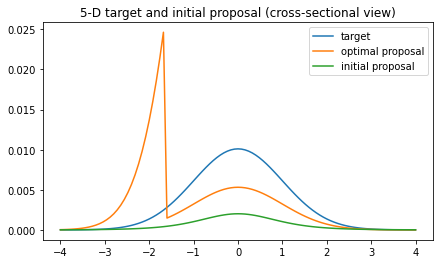

==NIS================================================NIS==
resampling rate: 186/200
bdwth: [0.96 0.78 0.71 0.85 0.67]
NIS est: -1.6386; err: 0.0063; a-var: 2.3777; a-err: 0.0109; ESS: 6478/20000; ESS(f): 2560/20000
MIS est: -1.6600; err: -0.0152; a-var: 2.4178; a-err: 0.0110; ESS: 7147/20000; ESS(f): 2403/20000


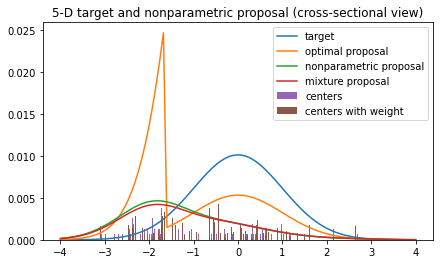

==RIS================================================RIS==
Condition index: (min 1.0000, median 3.6268, mean 5.0369, max 72.7490, [>30] 1/185)
Tail R2: 0.3160; Body R2: 0.7906; Total R2: 0.5054
RIS a-var: 1.1857; a-err: 0.0077


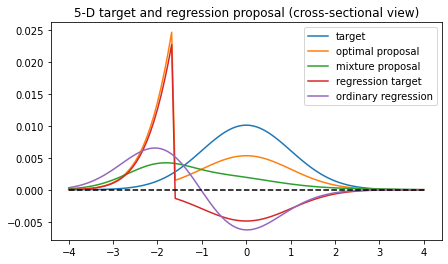

In [3]:
np.random.seed(1234)
print('==IS==================================================IS==')
mle=MLE(dim=5,alpha=0.05,sigma=2,size=20000,df=1)
mle.estimate_IS()
x=np.linspace(-4,4,101)
mle.draw_TP(mle.iP,x,'initial')
print('==NIS================================================NIS==')
mle.resample(200,100)
mle.estimate_NIS(0.9,kde=0)
mle.draw_TP(mle.nP,x,'nonparametric')
print('==RIS================================================RIS==')
mle.estimate_RIS()
mle.draw_TP(mle.mP,x,'regression')

==IS==================================================IS==
Reference for a-var & a-err (direct, optimal): [4.4656 0.8485] & [0.0067 0.0029]
IS est: -1.6535; err: -0.0087; a-var: 12.6071; a-err: 0.0112; ESS: 21925/100000; ESS(f): 1833/100000


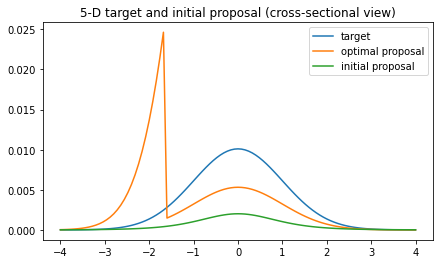

==NIS================================================NIS==
resampling rate: 936/1000
bdwth: [0.9  0.65 0.68 0.69 0.67]
NIS est: -1.6508; err: -0.0060; a-var: 2.0503; a-err: 0.0045; ESS: 42623/100000; ESS(f): 14112/100000
MIS est: -1.6423; err: 0.0025; a-var: 1.6304; a-err: 0.0040; ESS: 47188/100000; ESS(f): 18681/100000


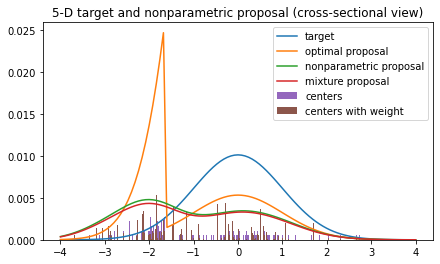

==RIS================================================RIS==
Condition index: (min 1.0000, median 11.8316, mean 33.1398, max 6896.5091, [>30] 223/935)
Tail R2: 0.4568; Body R2: 0.8555; Total R2: 0.6681
RIS a-var: 0.5493; a-err: 0.0023


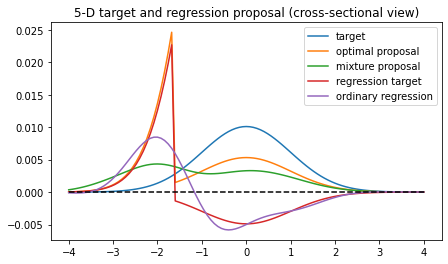

==MLE================================================MLE==
MLE reference:
origin: value: 8.5352; grad: (min -0.1870, mean -0.0000, max 0.1919, std 0.0347)

Theoretical results:
MLE(The) zeta: (min -0.1202, mean 0.0015, max 0.0746, std 0.0105, norm 0.3231)
theory: value: nan; grad: (min -0.8479, mean -0.0000, max 0.6780, std 0.0834)
reg weights: (min -0.1167, mean 0.9977, max 13.1092, [<0] 12/100000)
RIS est: -1.6464; err: -0.0016
(adjusted) RIS est: -1.6465; err: -0.0016
mle weights (The): (min -80.1748, mean 1.0014, max 203.2163, [<0] 46/100000)
MLE(The) est: -1.6478; err: -0.0029
(adjusted) MLE(The) est: -1.6482; err: -0.0034

Optimization results (spent 28 seconds):
MLE(Opt) zeta: (min -0.1445, mean 0.0015, max 0.0921, std 0.0115, norm 0.3561)
Dist(zeta(Opt),zeta(The))=0.0893
optimal: value: nan; grad: (min -0.0000, mean -0.0000, max 0.0000, std 0.0000)
mle weights (Opt): (min -7.3545, mean 1.0001, max 17.6968, [<0] 46/100000)
MLE(Opt) est: -1.6466; err: -0.0017
(adjusted) MLE(Opt) 

In [4]:
np.random.seed(1234)
print('==IS==================================================IS==')
mle=MLE(dim=5,alpha=0.05,sigma=2,size=100000,df=1)
mle.estimate_IS()
x=np.linspace(-4,4,101)
mle.draw_TP(mle.iP,x,'initial')
print('==NIS================================================NIS==')
mle.resample(1000,100)
mle.estimate_NIS(0.9,kde=0)
mle.draw_TP(mle.nP,x,'nonparametric')
print('==RIS================================================RIS==')
mle.estimate_RIS()
mle.draw_TP(mle.mP,x,'regression')
print('==MLE================================================MLE==')
mle.estimate_MLE()

**Summary:**
* Because the tail part is small, kernels of this part are highly correlated. 
* The performance of regression and MLE is limited by the tail approximation. 
* Regression can break the variance limit of self-normalized IS. 
* Rooting finding algorithm works well for control variables with only kernels. 
* Some weights based on regression or MLE are negative due to high density of the mixture proposal in the tail of the target, but the result is still somehow accurate and adjustment don't make too much difference. 

## Clustering KDE

==IS==================================================IS==
Reference for a-var & a-err (direct, optimal): [4.4656 0.8485] & [0.0149 0.0065]
IS est: -1.6380; err: 0.0068; a-var: 12.7049; a-err: 0.0252; ESS: 4441/20000; ESS(f): 364/20000


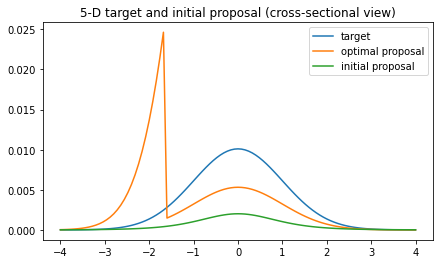

==NIS================================================NIS==
resampling rate: 186/200
bdwth 1: [0.28 0.79 0.75 0.9  0.68]
bdwth 2: [0.72 0.83 0.73 0.85 0.71]
NIS est: -1.6311; err: 0.0138; a-var: 2.1239; a-err: 0.0103; ESS: 6074/20000; ESS(f): 3135/20000
MIS est: -1.6512; err: -0.0063; a-var: 2.0084; a-err: 0.0100; ESS: 6423/20000; ESS(f): 3313/20000


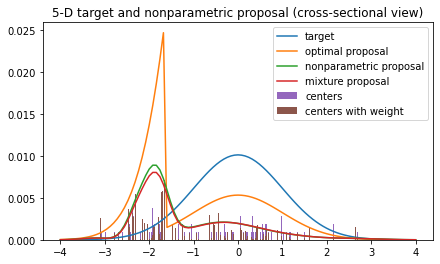

==RIS================================================RIS==
Condition index: (min 1.0000, median 3.3089, mean 4.2664, max 52.7897, [>30] 1/185)
Tail R2: 0.5425; Body R2: 0.8045; Total R2: 0.7506
RIS a-var: 0.4990; a-err: 0.0050


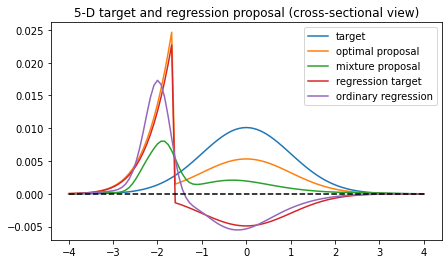

In [5]:
np.random.seed(1234)
print('==IS==================================================IS==')
mle=MLE(dim=5,alpha=0.05,sigma=2,size=20000,df=1)
mle.estimate_IS()
x=np.linspace(-4,4,101)
mle.draw_TP(mle.iP,x,'initial')
print('==NIS================================================NIS==')
mle.resample(200,100)
mle.estimate_NIS(0.9,kde=1)
mle.draw_TP(mle.nP,x,'nonparametric')
print('==RIS================================================RIS==')
mle.estimate_RIS()
mle.draw_TP(mle.mP,x,'regression')

==IS==================================================IS==
Reference for a-var & a-err (direct, optimal): [4.4656 0.8485] & [0.0067 0.0029]
IS est: -1.6535; err: -0.0087; a-var: 12.6071; a-err: 0.0112; ESS: 21925/100000; ESS(f): 1833/100000


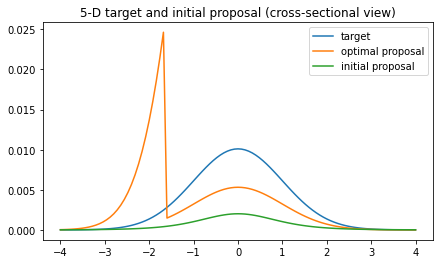

==NIS================================================NIS==
resampling rate: 936/1000
bdwth 1: [0.29 0.66 0.7  0.73 0.71]
bdwth 2: [0.61 0.7  0.71 0.71 0.69]
NIS est: -1.6402; err: 0.0047; a-var: 1.4296; a-err: 0.0038; ESS: 34704/100000; ESS(f): 28114/100000
MIS est: -1.6442; err: 0.0006; a-var: 1.3443; a-err: 0.0037; ESS: 42427/100000; ESS(f): 26761/100000


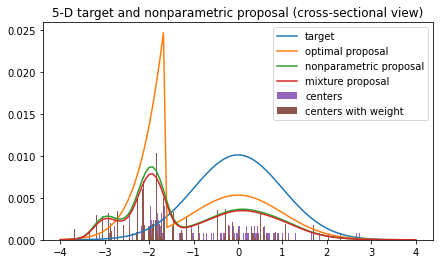

==RIS================================================RIS==
Condition index: (min 1.0000, median 9.5149, mean 19.0447, max 1591.8331, [>30] 140/935)
Tail R2: 0.7004; Body R2: 0.8530; Total R2: 0.8848
RIS a-var: 0.1560; a-err: 0.0012


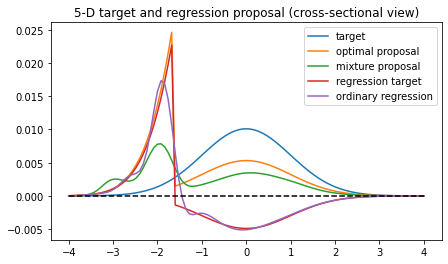

==MLE================================================MLE==
MLE reference:
origin: value: 8.3866; grad: (min -0.3207, mean -0.0000, max 0.2200, std 0.0376)

Theoretical results:
MLE(The) zeta: (min -0.0671, mean -0.0024, max 0.0615, std 0.0055, norm 0.1837)
theory: value: nan; grad: (min -1.5045, mean -0.0000, max 2.6634, std 0.1570)
reg weights: (min -0.1785, mean 0.9973, max 17.0348, [<0] 7/100000)
RIS est: -1.6435; err: 0.0013
(adjusted) RIS est: -1.6436; err: 0.0012
mle weights (The): (min -315.3305, mean 0.9977, max 46.6012, [<0] 12/100000)
MLE(The) est: -1.6172; err: 0.0276
(adjusted) MLE(The) est: -1.6448; err: 0.0001

Optimization results (spent 29 seconds):
MLE(Opt) zeta: (min -0.0821, mean -0.0022, max 0.0763, std 0.0058, norm 0.1910)
Dist(zeta(Opt),zeta(The))=0.0285
optimal: value: nan; grad: (min -0.0000, mean 0.0000, max 0.0000, std 0.0000)
mle weights (Opt): (min -7.7182, mean 1.0004, max 17.4389, [<0] 12/100000)
MLE(Opt) est: -1.6435; err: 0.0014
(adjusted) MLE(Opt) est: 

In [6]:
np.random.seed(1234)
print('==IS==================================================IS==')
mle=MLE(dim=5,alpha=0.05,sigma=2,size=100000,df=1)
mle.estimate_IS()
x=np.linspace(-4,4,101)
mle.draw_TP(mle.iP,x,'initial')
print('==NIS================================================NIS==')
mle.resample(1000,100)
mle.estimate_NIS(0.9,kde=1)
mle.draw_TP(mle.nP,x,'nonparametric')
print('==RIS================================================RIS==')
mle.estimate_RIS()
mle.draw_TP(mle.mP,x,'regression')
print('==MLE================================================MLE==')
mle.estimate_MLE()

**Summary:**
* A compromise between standard KDE and adaptive KDE. 